In [61]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from BS_pricer import BS_pricer
from Parameters import Option_param
from Processes import Diffusion_process

Den originale ligning (3.81) kan omskrives:

\begin{align*}
S\left(t\right)&=S\left(0\right)e^{\left(\mu-\frac{1}{2}\sigma^{2}\right)t+\sigma W\left(t\right)}\prod_{J=1}^{N\left(t\right)}Y_{J}\\\ln\left(S\left(t\right)\right)&=\ln\left(S\left(0\right)e^{\left(\mu-\frac{1}{2}\sigma^{2}\right)t+\sigma W\left(t\right)}\prod_{J=1}^{N\left(t\right)}Y_{J}\right)\\\ln\left(S\left(t\right)\right)&=\ln\left(S\left(0\right)\right)+\ln\left(e^{\left(\mu-\frac{1}{2}\sigma^{2}\right)t+\sigma W\left(t\right)}\right)+\ln\left(\prod_{J=1}^{N\left(t\right)}Y_{J}\right)\\\ln\left(S\left(t\right)\right)&=\ln\left(S\left(0\right)\right)+\left(\mu-\frac{1}{2}\sigma^{2}\right)t+\sigma W\left(t\right)+\sum_{J=1}^{N\left(t\right)}Y_{J}\\\exp\left(\ln\left(S\left(t\right)\right)\right)&=\exp\left(\ln\left(S\left(0\right)\right)+\left(\mu-\frac{1}{2}\sigma^{2}\right)t+\sigma W\left(t\right)+\sum_{J=1}^{N\left(t\right)}Y_{J}\right)\\S_{t}&=S\left(0\right)\exp\left(\underset{GBM}{\underbrace{\left(\mu-\frac{1}{2}\sigma^{2}\right)t+\sigma W\left(t\right)}}+\underset{\text{Jumps}}{\underbrace{\sum_{J=1}^{N\left(t\right)}Y_{J}}}\right)
\end{align*}

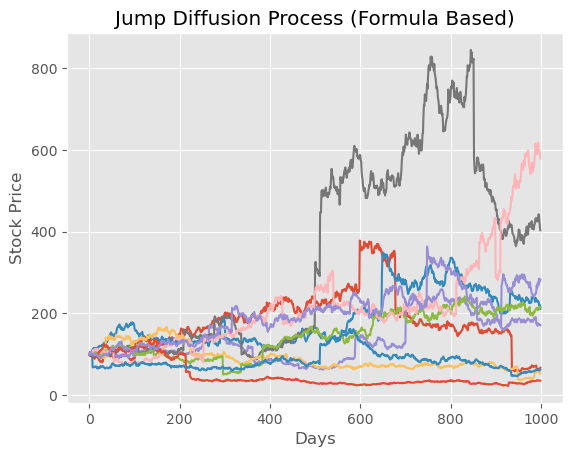

In [86]:
def merton_jump_paths_formula(S0, T, mu, sigma, lam, m, v, I, Npaths):
    dt = T / I  # Time increment
    t = np.linspace(0, T, I)  # Time grid
    
    # GBM component
    # Generate random Brownian motion paths
    W = np.random.randn(I, Npaths).cumsum(axis=0) * np.sqrt(dt)  # Cumulative sum of standard normals times sqrt(dt) gives W(t)
    # Calculate the geometric Brownian motion component for each path and time step
    GBM = (mu - 0.5 * sigma**2) * t[:, np.newaxis] + sigma * W
    
    # Jump component
    # Generate Poisson processes for jumps for each path and time step
    N = np.random.poisson(lam * dt, (I, Npaths)).cumsum(axis=0)  # Cumulative sum of Poisson gives N(t)
    # Generate jump sizes for each potential jump event; these are drawn from a log-normal distribution
    Y = np.exp(np.random.normal(m, v, (I, Npaths)))  # Jump sizes, which are log-normal
    # Initialize a matrix to hold the cumulative sum of jumps for each path
    jumps = np.zeros((I, Npaths))
    
    # Calculate the cumulative sum of jumps for each path
    for i in range(1, I):
        # For each time step, if there is a new jump (N[i] > N[i-1]), add its logarithm to the cumulative sum of jumps
        jumps[i] = jumps[i - 1] + np.where(N[i] > N[i - 1], np.log(Y[i]), 0)
    
    # Calculate the final price paths by combining the GBM and jump components and multiplying by the initial stock price
    return S0 * np.exp(GBM + jumps)


# Parameters
S0 = 100  # current stock price
T = 10  # time to maturity
mu = 0.02  # risk free rate
m = 0  # mean of jump size
v = 0.3  # standard deviation of jump
lam = 1  # intensity of jump i.e. number of jumps per annum
I = 1000  # time steps
Npaths = 10  # number of paths to simulate
sigma = 0.2  # annual standard deviation, for Wiener process

# Simulate paths
j = merton_jump_paths_formula(S0, T, mu, sigma, lam, m, v, I, Npaths)

# Plotting
plt.plot(j)
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Jump Diffusion Process (Formula Based)')
plt.show()

Text(0.5, 1.0, 'Jump Diffusion Process')

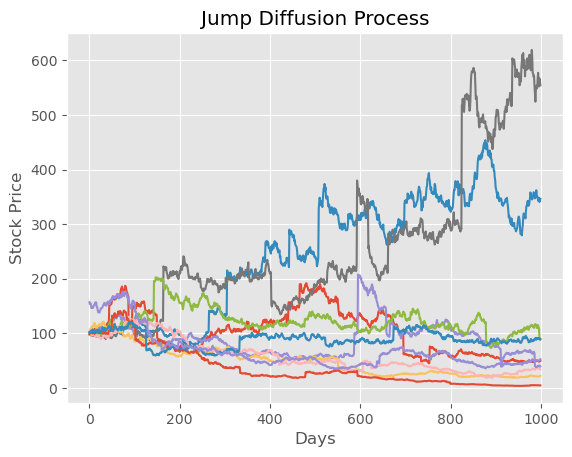

In [81]:
def merton_jump_paths(S0, T, mu, sigma,  lam, m, v, I, Npaths):
    size=(I,Npaths)
    dt = T/I 

    poi_rv = np.multiply(np.random.poisson( lam*dt, size=size), np.random.normal(m,v, size=size)).cumsum(axis=0)

    geo = np.cumsum(((mu -  sigma**2/2 -lam*(m  + v**2*0.5))*dt + sigma*np.sqrt(dt) * np.random.normal(size=size)), axis=0)
    
    return np.exp(geo+poi_rv)*S0

S0 = 100 # current stock price
T = 10 # time to maturity
mu = 0.02 # risk free rate
m = 0 # meean of jump size
v = 0.3 # standard deviation of jump
lam =1 # intensity of jump i.e. number of jumps per annum
I = 1000 # time steps
Npaths = 10 # number of paths to simulate
sigma = 0.2 # annaul standard deviation , for weiner process

j = merton_jump_paths(S0, T, mu, sigma, lam, m, v, I, Npaths)

plt.plot(j)
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Jump Diffusion Process')

[[100.          98.07974951 102.77173095 ...  87.9571805   87.44029802
   87.00664057]
 [100.          99.91812878  97.1953107  ... 104.21489097 103.18996265
  104.49944377]
 [100.         104.30055585 106.86647128 ...  79.45596918  77.56857458
   76.83624456]
 ...
 [100.          96.43705267  96.09378599 ...  76.34174275  76.35101328
   77.38371195]
 [100.         100.46885071 101.23710651 ... 101.55481418 101.93129215
  102.30069193]
 [100.          98.09792476  96.65862274 ... 114.35480271 112.06895137
  114.49182246]]


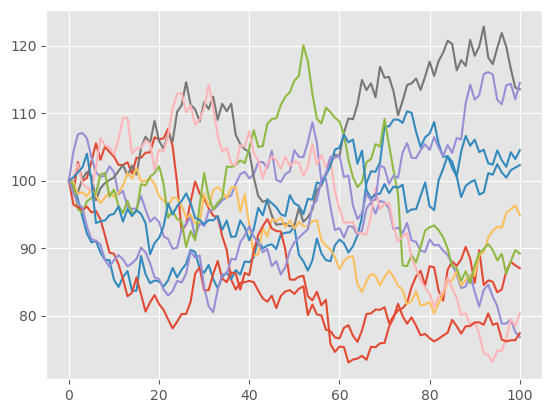

In [74]:
import numpy as np

def sample_paths_merton(S0, T, mu, sigma, lam, Y_dist, I, Npaths):
    """
    Simulate sample paths using the modified Merton Jump Diffusion model.

    Parameters:
    - S0: Initial asset price
    - T: Total time
    - mu: Expected return (drift)
    - sigma: Volatility of the continuous component
    - lam: Expected number of jumps in one time unit
    - Y_dist: A function that generates a random number from the Y distribution
    - I: Number of time intervals (steps)
    - Npaths: Number of paths to simulate

    Returns:
    - A 2D array of asset prices with shape (Npaths, I+1)
    """
    
    dt = T / I  # Time step size
    paths = np.zeros((Npaths, I+1))
    
    for path in range(Npaths):
        paths[path, 0] = S0
        X = np.log(S0)
        
        for i in range(1, I+1):
            Z = np.random.normal(0, 1)
            N = np.random.poisson(lam * dt)
            M = np.sum(np.log(Y_dist(size=N)))

            X += (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z + M
            paths[path, i] = np.exp(X)
    
    return paths

# Test the function using a uniform distribution for Y
Y_distribution = lambda size: np.random.uniform(0.9, 1.1, size)
paths = sample_paths_merton(S0=100, T=1, mu=0.05, sigma=0.2, lam=0.8, Y_dist=Y_distribution, I=100, Npaths=10)
print(paths)

plt.plot(paths.T)


[[100.         101.34732617 101.23805151 ...   0.           0.
    0.        ]
 [100.          99.88683906 102.51608648 ...   0.           0.
    0.        ]
 [100.         103.38425375 104.3818139  ... 142.42580041 140.24248251
  143.03203933]
 ...
 [100.         101.78341762 100.95466346 ... 138.79195715 138.61958995
  140.70723752]
 [100.          98.73461138  97.45384395 ...   0.           0.
    0.        ]
 [100.         101.51673981 107.8193865  ...   0.           0.
    0.        ]]


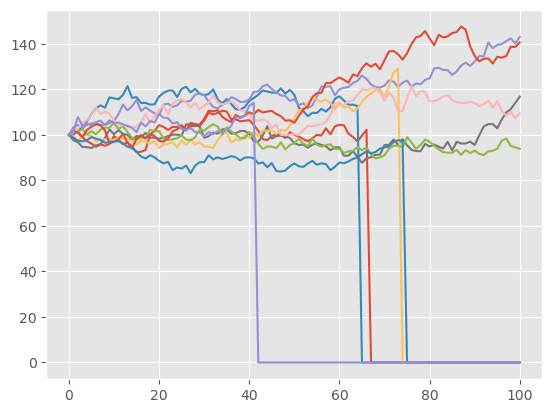

In [65]:
import numpy as np

def sample_paths_merton_drop(S0, T, mu, sigma, lam, I, Npaths):
    """
    Simulate sample paths using Merton Jump Diffusion model.

    Parameters:
    - S0: Initial asset price
    - T: Total time
    - mu: Expected return (drift)
    - sigma: Volatility of the continuous component
    - lam: Jump intensity
    - I: Number of time intervals (steps)
    - Npaths: Number of paths to simulate

    Returns:
    - A 2D array of asset prices with shape (Npaths, I+1)
    """
    
    dt = T / I  # Time step size
    paths = np.zeros((Npaths, I+1))
    
    for path in range(Npaths):
        paths[path, 0] = S0
        X = np.log(S0)
        
        for i in range(1, I+1):
            Z = np.random.normal(0, 1)
            N = np.random.poisson(lam * dt)

            if N == 0 and paths[path, i-1] > 0:
                X += (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
                paths[path, i] = np.exp(X)
            else:
                paths[path, i] = 0
    
    return paths

# Test the function
paths_1 = sample_paths_merton_drop(S0=100, T=1, mu=0.05, sigma=0.2, lam=0.8, I=100, Npaths=10)
print(paths_1)

plt.plot(paths_1.T)